# 参考サイト
[日本一詳しくGrad-CAMとGuided Grad-CAMのソースコードを解説してみる(Keras実装)](https://qiita.com/kinziro/items/69f996065b4a658c42e8)

In [1]:
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import pandas as pd

from sklearn.metrics import accuracy_score


In [3]:
# 学習する場合
is_learning = True

In [4]:

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [5]:

def load_image(path):
    #img_path = sys.argv[1]
    img_path = path
    img = image.load_img(img_path, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


# 使用できるGPUのメモリ確認

In [6]:
import GPUtil as GPU
import psutil
import os
import humanize
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 16.5 GB  | Proc size: 270.5 MB
GPU RAM Free: 584MB | Used: 952MB | Util  62% | Total 1536MB


In [7]:
img_width, img_height = 128, 128

# VGGモデル作成関数

In [8]:
def get_teni_model(nb_classes,img_width=128, img_heigh=128):
    input_tensor = Input(shape=(img_width, img_height, 3))
    # include_top=False 出力層なし
    model = VGG16(include_top=False,classes=nb_classes, weights='imagenet',input_tensor=input_tensor)
    x=model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes, activation='softmax')(x)
    # VGG16とFC層を結合してモデルを作成（完成図が上の図）
    vgg_model= Model(input=model.input, output=x)

    # VGG16の図の青色の部分は重みを固定（frozen）
    for layer in vgg_model.layers[:15]:
        layer.trainable = False

    # 多クラス分類を指定
    vgg_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

    return vgg_model

In [9]:
vgg_model = get_teni_model(2)

C:\Users\mopper\AppData\Local\conda\conda\envs\keras_work\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [10]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  #すでに画像の水増し済みの方は、下記２行は必要ありません。
  #zoom_range=0.2,
  #horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

validation_datagen

In [11]:
# 訓練データ保存先
# /保存先フォルダ/ {0 or 1 } / *.png
classes=["0","1"]
classes_name =["輿水幸子","森久保乃々"]
train_data_dir="Y:/MLearningData/SatiMori/"
#トレーニングデータ用の画像数
#バッチサイズ
batch_size = 12


In [12]:
# 訓練データ
train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 3071 images belonging to 2 classes.


In [13]:
# テストデータ
validation_data_dir=  "Y:/MLearningData/SatiMori/test"
validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 54 images belonging to 2 classes.


In [14]:
# テストデータ（評価用
validation_data_dir=  "Y:/MLearningData/SatiMori/test"
validation_generator2 = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=1,
  shuffle=False)

Found 54 images belonging to 2 classes.


In [15]:
#エポック数
nb_epoch = 2

In [16]:
# 訓練する場合
if is_learning:
    # Fine-tuning
    history = vgg_model.fit_generator(
        train_generator,
        # samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        # nb_val_samples=nb_validation_samples
    )
    vgg_model.save('vgg_model') 
else:
    vgg_model.save_weights("vgg_model_weights")


C:\Users\mopper\AppData\Local\conda\conda\envs\keras_work\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\mopper\AppData\Local\conda\conda\envs\keras_work\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., epochs=2)`
  


Epoch 1/2
256/256 [==============================] - 52s 202ms/step - loss: 0.0851 - accuracy: 0.9619 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 2/2
256/256 [==============================] - 43s 167ms/step - loss: 3.8931e-04 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 1.0000


In [17]:
def write_cv(img,output_path,dummy_path="./tmp.jpg"):
    if cv2.imwrite(dummy_path, img)==False:
        return False
    if os.path.exists(output_path):
        os.remove(output_path)
    shutil.move(dummy_path,output_path)
    return True
    

In [18]:
K.set_learning_phase(0)

In [19]:
img_width, img_height

(128, 128)

In [67]:
folder_path = "Y:/MLearningData/SatiMori/test/"
name_list=["輿水幸子","森久保乃々"]
prob_all =pd.DataFrame()
for i in range(2):
    glob_path = folder_path+str(i)+"/*.*"
    output_folder="./test/"+str(i)+"/"

    file_list = glob.glob(glob_path)
    
    predict0=[]
    predict1=[]
    predict2=[]
    predict2_name=[]
    ok_list=[]
    base_name_list =[]
    for file_path in file_list:
        print(file_path)
        base_name = os.path.basename(file_path)
        preprocessed_input_base = load_image(file_path)        
        p_image = preprocessed_input_base/255.0
        predict = vgg_model.predict(p_image,batch_size=1)
        print(predict)
        print(predict.shape)
        predict0.append(predict[0][0])
        predict1.append(predict[0][1])
        base_name_list.append(base_name)
        predict2.append(np.argmax(predict[0]))
        predict2_name.append(name_list[predict2[-1]])
        ok_list.append(np.argmax(predict[0])==i)
    prob = pd.DataFrame({name_list[0]:predict0,name_list[1]:predict1,"file_name":base_name_list})
    prob["答"]=int(i)
    prob["予測値"]=predict2
    prob["答_名"]=name_list[i]
    prob["予測名"]=predict2_name
    prob["正しく予測"]=ok_list
    prob_all = prob_all.append(prob)

Y:/MLearningData/SatiMori/test/0\1475050980001.jpg
[[0.9072201 0.0927799]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1485243510001.jpg
[[9.999908e-01 9.145149e-06]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1485243920001.jpg
[[0.95578724 0.04421281]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1499050605.jpg
[[9.9999988e-01 1.2152366e-07]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1499050618.jpg
[[9.9999702e-01 2.9501484e-06]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1539139457.jpg
[[0.77961105 0.22038896]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1539139906.jpg
[[0.984396 0.015604]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1588392638.jpg
[[9.9999833e-01 1.7283082e-06]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1588392638_2.jpg
[[0.9981553  0.00184466]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1588392645 (1).jpg
[[0.9976597 0.0023403]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1588392645 (2).jpg
[[0.049554 0.950446]]
(1, 2)
Y:/MLearningData/SatiMori/test/0\1589898129001 (1).jpg
[[0.998744   0.00125601]]

In [69]:
prob_all

,輿水幸子,森久保乃々,file_name,答,予測値,答_名,予測名,正しく予測
0,0.907,0.093,1475050980001.jpg,0,0,輿水幸子,輿水幸子,True
1,1.000,0.000,1485243510001.jpg,0,0,輿水幸子,輿水幸子,True
2,0.956,0.044,1485243920001.jpg,0,0,輿水幸子,輿水幸子,True
3,1.000,0.000,1499050605.jpg,0,0,輿水幸子,輿水幸子,True
4,1.000,0.000,1499050618.jpg,0,0,輿水幸子,輿水幸子,True
5,0.780,0.220,1539139457.jpg,0,0,輿水幸子,輿水幸子,True
6,0.984,0.016,1539139906.jpg,0,0,輿水幸子,輿水幸子,True
7,1.000,0.000,1588392638.jpg,0,0,輿水幸子,輿水幸子,True
8,0.998,0.002,1588392638_2.jpg,0,0,輿水幸子,輿水幸子,True
9,0.998,0.002,1588392645 (1).jpg,0,0,輿水幸子,輿水幸子,True


In [68]:
print("accuracy")
print(accuracy_score( prob_all["答"], prob_all["予測値"]))

accuracy
0.8888888888888888


In [24]:
pd.options.display.precision = 3
pd.options.display.float_format = '{:.3f}'.format

In [26]:
print("accuracy")
print(accuracy_score( prob_all["答"], prob_all["予測値"]))

accuracy
0.42592592592592593


In [27]:

def grad_cam(input_model, imagedata, category_index, layer_name):
    nb_classes = 2
    # 入力データxのcategory_indexで指定したインデックス以外を0にする処理の定義
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    # 引数のinput_modelの出力層の後にtarget_layerレイヤーを追加
    # modelのpredictをすると予測クラス以外の値は0になる
    x = input_model.layers[-1].output
    # x = input_model.layers[-1].outputs
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)
    # 予測クラス以外の値は0なのでsumをとって予測クラスの値のみ抽出
    loss = K.sum(model.layers[-1].output)
    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
    # 引数のlayer_nameのレイヤー(最後のconv層)のoutputを取得する    
    conv_output = [l for l in model.layers if l.name is layer_name][0].output
    
    # ----- 3. 予測クラスのLossから最後のconv層への逆伝搬(勾配)を計算 -----
    
    # 予想クラスの値から最後のconv層までの勾配を計算する関数を定義
    # 定義した関数の
    # 入力 : [判定したい画像.shape=(1, 224, 224, 3)]、
    # 出力 : [最後のconv層の出力値.shape=(1, 14, 14, 512), 予想クラスの値から最後のconv層までの勾配.shape=(1, 14, 14, 512)]
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    # 前処理
    p_image = imagedata/255.0
    # 定義した勾配計算用の関数で計算し、データの次元を整形
    # 整形後
    # output.shape=(14, 14, 512), grad_val.shape=(14, 14, 512
    output, grads_val = gradient_function([p_image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    # weights.shape=(512, )
    # cam.shape=(14, 14)
    # ※疑問点1：camの初期化はzerosでなくて良いのか?
    weights = np.mean(grads_val, axis = (0, 1))
    # cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    cam = np.zeros(output.shape[0 : 2], dtype = np.float32)    # 私の自作モデルではこちらを使用

    # ----- 5. 最後のconv層の順伝搬の出力にチャンネル毎の重みをかけて、足し合わせて、ReLUを通す -----

    # 最後のconv層の順伝搬の出力にチャンネル毎の重みをかけて、足し合わせ
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # 入力画像のサイズにリサイズ
    cam = cv2.resize(cam, (img_width, img_height))
    # 負の値を0に置換。処理としてはReLUと同じ。
    cam = np.maximum(cam, 0)
    # 値を0~1に正規化。
    # ※疑問2 : (cam - np.min(cam))/(np.max(cam) - np.min(cam))でなくて良いのか?
    heatmap = cam / np.max(cam)

    # 入力画像imageの値を0~255に正規化. image.shape=(1, 224, 224, 3) → (224, 224, 3)
    #Return to BGR [0..255] from the preprocessed imag
    #Return to BGR [0..255] from the preprocessed image
    imagedata = imagedata[0, :]
    imagedata -= np.min(imagedata)
    imagedata = np.minimum(imagedata, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(imagedata)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap



In [28]:
import matplotlib.pyplot as plt

Y:/MLearningData/SatiMori/test/0\1589898129002.jpg


W1124 21:58:12.849649 16504 font_manager.py:1282] findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


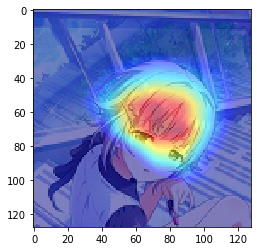

In [29]:
folder_path = "Y:/MLearningData/SatiMori/test/"

file_list = glob.glob(folder_path+str(0)+"/*.*")

file_path=file_list[13]
print(file_path)
preprocessed_input_base = load_image(file_path)

cam, heatmap = grad_cam(vgg_model, preprocessed_input_base, 0, "block5_conv3")
img = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

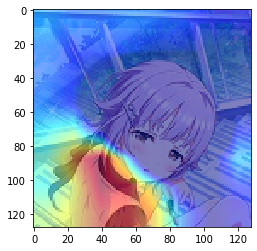

In [30]:
cam, heatmap = grad_cam(vgg_model, preprocessed_input_base, 1, "block5_conv3")
img = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [31]:
import shutil

Y:/MLearningData/SatiMori/test/0\1475050980001.jpg
./test/0/1475050980001.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1485243510001.jpg
./test/0/1485243510001.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1485243920001.jpg
./test/0/1485243920001.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1499050605.jpg
./test/0/1499050605.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1499050618.jpg
./test/0/1499050618.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1539139457.jpg
./test/0/1539139457.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1539139906.jpg
./test/0/1539139906.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1588392638.jpg
./test/0/1588392638.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1588392638_2.jpg
./test/0/1588392638_2.jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1588392645 (1).jpg
./test/0/1588392645 (1).jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/test/0\1588392645 (2).jpg
./test/0/1588392645 (2).jpg_gradcam0.jpg
Y:/MLearningData/SatiMori/t

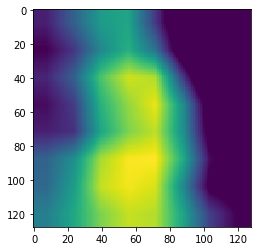

In [32]:
folder_path = "Y:/MLearningData/SatiMori/test/"

for i in range(2):
    glob_path = folder_path+str(i)+"/*.*"
    output_folder="./test/"+str(i)+"/"

    file_list = glob.glob(glob_path)
    
    
    for file_path in file_list:
        print(file_path)
        base_name = os.path.basename(file_path)
        output_copy = output_folder+base_name
        preprocessed_input_base = load_image(file_path)
        shutil.copyfile(file_path,output_copy)

        
        # 自作モデルの場合、引数の"block5_conv3"を自作モデルの最終conv層のレイヤー名に変更.
        cam, heatmap = grad_cam(vgg_model, preprocessed_input_base, i, "block5_conv3")
        output_path= output_folder+base_name+"_gradcam0.jpg"
        print(output_path)
        write_cv(cam,output_path)
        output_path= output_folder+base_name+"_gradcam1.jpg"
        plt.imshow(heatmap*255)
        plt.savefig(output_path)
        


In [33]:
prob_all

,輿水幸子,森久保乃々,file_name,答,予測値,答_名,予測名
0,0.907,0.093,1475050980001.jpg,1,0,森久保乃々,輿水幸子
1,1.000,0.000,1485243510001.jpg,1,0,森久保乃々,輿水幸子
2,0.956,0.044,1485243920001.jpg,1,0,森久保乃々,輿水幸子
3,1.000,0.000,1499050605.jpg,1,0,森久保乃々,輿水幸子
4,1.000,0.000,1499050618.jpg,1,0,森久保乃々,輿水幸子
5,0.780,0.220,1539139457.jpg,1,0,森久保乃々,輿水幸子
6,0.984,0.016,1539139906.jpg,1,0,森久保乃々,輿水幸子
7,1.000,0.000,1588392638.jpg,1,0,森久保乃々,輿水幸子
8,0.998,0.002,1588392638_2.jpg,1,0,森久保乃々,輿水幸子
9,0.998,0.002,1588392645 (1).jpg,1,0,森久保乃々,輿水幸子


In [71]:
folder_path = "Y:/MLearningData/SatiMori/test/"
target_prob = prob_all[prob_all["正しく予測"]==False]

for i in range(2):
    target=target_prob[target_prob["答"]==i]
    output_folder="./ng/"+str(i)+"/"
    for t in range(len(target)):
        base_name =target["file_name"].iloc[t] 
        file_path=folder_path+str(i)+"/"+base_name
        output_copy = output_folder+base_name
        preprocessed_input_base = load_image(file_path)
        shutil.copyfile(file_path,output_copy)
        
        # 自作モデルの場合、引数の"block5_conv3"を自作モデルの最終conv層のレイヤー名に変更.
        cam, heatmap = grad_cam(vgg_model, preprocessed_input_base, 0, "block5_conv3")
        output_path= output_folder+base_name+"_gradcam0.jpg"
        print(output_path)
        write_cv(cam,output_path)
        cam, heatmap = grad_cam(vgg_model, preprocessed_input_base, 1, "block5_conv3")
        output_path= output_folder+base_name+"_gradcam1.jpg"
        print(output_path)
        write_cv(cam,output_path)
        


./ng/0/1588392645 (2).jpg_gradcam0.jpg
./ng/0/1588392645 (2).jpg_gradcam1.jpg
./ng/0/ani2.jpg_gradcam0.jpg
./ng/0/ani2.jpg_gradcam1.jpg
./ng/1/1543219880.jpg_gradcam0.jpg
./ng/1/1543219880.jpg_gradcam1.jpg
./ng/1/1588396030.jpg_gradcam0.jpg
./ng/1/1588396030.jpg_gradcam1.jpg
./ng/1/1605778609009.jpg_gradcam0.jpg
./ng/1/1605778609009.jpg_gradcam1.jpg
./ng/1/DI-VxjDUEAEH-vj.jpg_gradcam0.jpg
./ng/1/DI-VxjDUEAEH-vj.jpg_gradcam1.jpg


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23     True
24    False
25    False
26    False
27    False
28    False
0     False
1     False
2     False
3      True
4     False
5      True
6     False
7      True
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
Name: 正しく予測, dtype: bool

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23     True
24    False
25    False
26    False
27    False
28    False
0     False
1     False
2     False
3      True
4     False
5      True
6     False
7      True
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
Name: 正しく予測, dtype: bool